# HOMEWORK 7

In this homework, the goal was to analyze different geometric approaches for rectifying a document affected by severe perspective distortion. 

Using the same image and previously detected corner points from Lesson 6, affine and projective transformations (homography) were compared in order to analyze their capabilities and limitations.

In [ ]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [191]:
def compare_two_images(img1, img2, title1="Image 1", title2="Image 2", figsize=(14,7)):
    plt.figure(figsize=figsize)

    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis("on")

    plt.subplot(1,2,2)

    if len(img2.shape) == 3:
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))  # ✅ исправлено
    else:
        plt.imshow(img2, cmap="gray")

    plt.title(title2)
    plt.axis("on")

    plt.tight_layout()
    plt.show()

In [192]:
img = cv2.imread('data/document.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

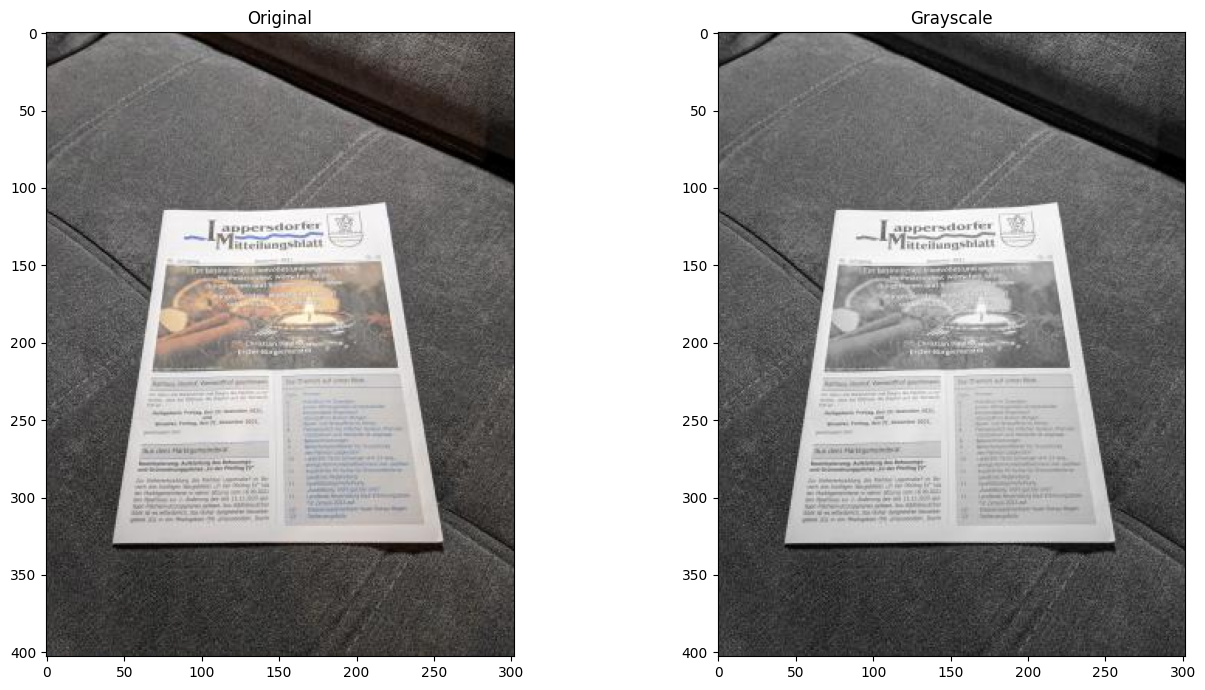

In [242]:
compare_two_images(img, gray, 'Original', 'Grayscale')

The document corners were automatically detected using a custom implementation. 
The approach consists of grayscale conversion, Gaussian smoothing, Canny edge detection, morphological closing, contour extraction, and convex hull approximation. 
The largest contour was assumed to correspond to the document, and its extreme points were used to estimate the four corner coordinates.

In [ ]:
def detect_document_corners(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 0)

    edges = cv2.Canny(gray, 50, 150)

    kernel = np.ones((7,7), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(edges,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    largest = max(contours, key=cv2.contourArea)

    hull = cv2.convexHull(largest)

    peri = cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, 0.02 * peri, True)

    pts = approx.reshape(-1, 2)

    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return tuple(np.round(rect[0]).astype(int)), \
           tuple(np.round(rect[1]).astype(int)), \
           tuple(np.round(rect[3]).astype(int)), \
           tuple(np.round(rect[2]).astype(int))

In [196]:
corners = detect_document_corners(img)
top_left, top_right, bottom_left, bottom_right = corners
print(f'top_left = {top_left}')
print(f'top_right = {top_right}')
print(f'bottom_left = {bottom_left}')
print(f'bottom_right = {bottom_right}')

top_left = (75, 116)
top_right = (218, 110)
bottom_left = (43, 329)
bottom_right = (255, 328)


In [199]:
out = np.copy(img)
out = cv2.circle(out, tuple(top_left), 3, (0,255,0), -1)
out = cv2.circle(out, tuple(top_right), 3, (0,255,0), -1)
out = cv2.circle(out, tuple(bottom_left), 3, (0,255,0), -1)
out = cv2.circle(out, tuple(bottom_right), 3, (0,255,0), -1)

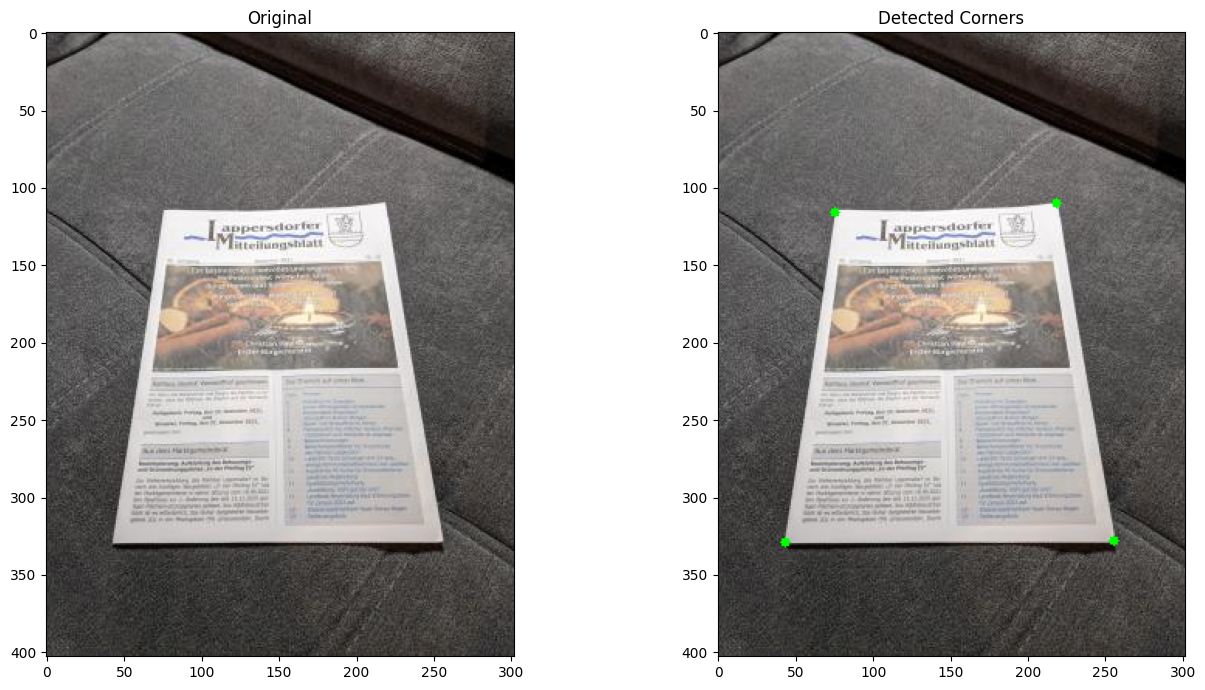

In [200]:
compare_two_images(img, out, 'Original', 'Detected Corners')

## 1. Document Rectification: Selection of an Appropriate Transformation Model

The goal is to transform the detected document corners so that they align with the image boundaries, allowing the document to fill the entire frame while removing the background. To determine the most suitable solution, several geometric transformation models are evaluated and compared.


At this stage, two sets of corresponding points are defined.

The `src` matrix contains the coordinates of the detected document corners in the original image.

The `dst` matrix contains the coordinates of the target corner positions in the rectified image (typically the image boundaries).

Both matrices must have shape (4, 2), since four corner points are used, each defined by x and y coordinates. The order of points in both matrices must be consistent to ensure correct geometric mapping.


In [201]:
src = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)

dst = np.array([[0, 0],
                [cols-1, 0],
                [cols-1, rows-1],
                [0, rows-1]], dtype=np.float32)


### 1.1 Affine Transformation (First Experiment)

In the first experiment, an affine transformation is applied to attempt document rectification.  
The transformation matrix is computed using the first three corner correspondences, since three point pairs are sufficient for an affine model.  

The computed affine matrix is then applied to the image to obtain a rectified result, which is analyzed to evaluate whether affine transformation can adequately correct the distortion.

In [202]:
M = cv2.getAffineTransform(src[:3], dst[:3])

rectified_1 = cv2.warpAffine(img, M, (cols, rows))

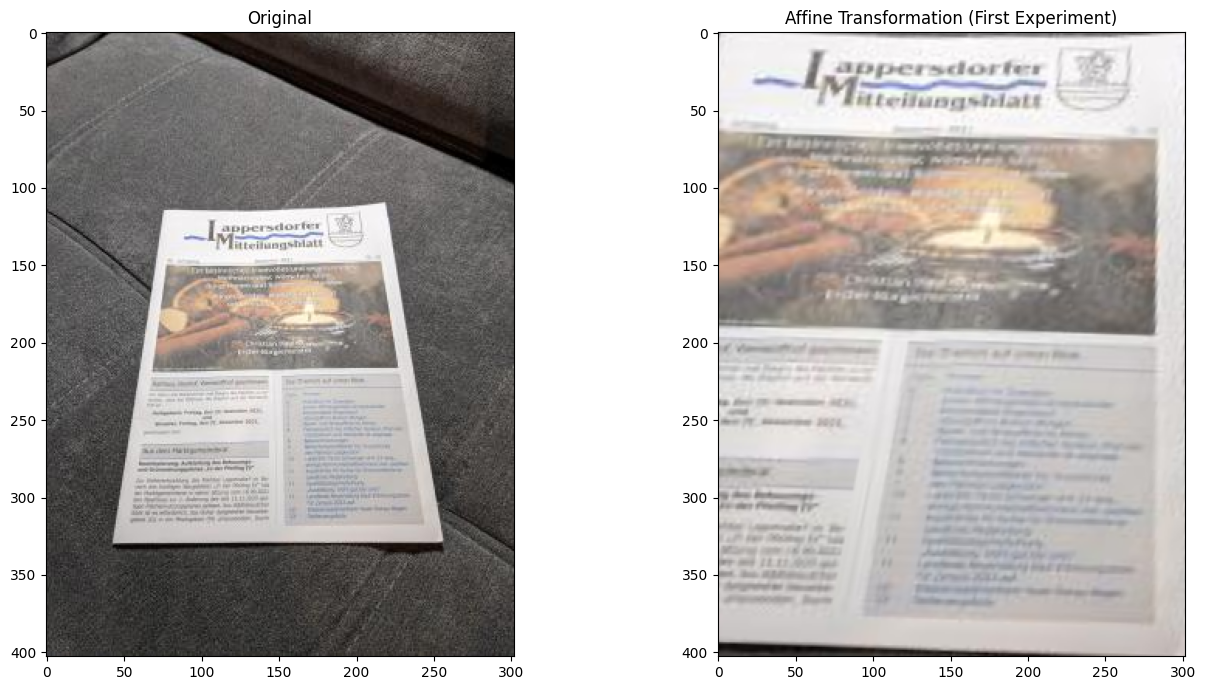

In [203]:
compare_two_images(img, rectified_1, 'Original', 'Affine Transformation (First Experiment)')

The affine transformation did not produce a satisfactory result. Although the document was partially transformed, the perspective distortion was not properly corrected, and the geometry remained visibly inaccurate.

### 1.2 Affine Transformation (Second Experiment)

In the second experiment, the affine transformation matrix is recomputed using a different subset of three corner correspondences.  

The matrix is applied to the image to determine whether changing the selected point pairs affects the rectification result.  

In [158]:
M = cv2.getAffineTransform(src[1:], dst[1:])

rectified_2 = cv2.warpAffine(img, M, (cols, rows))

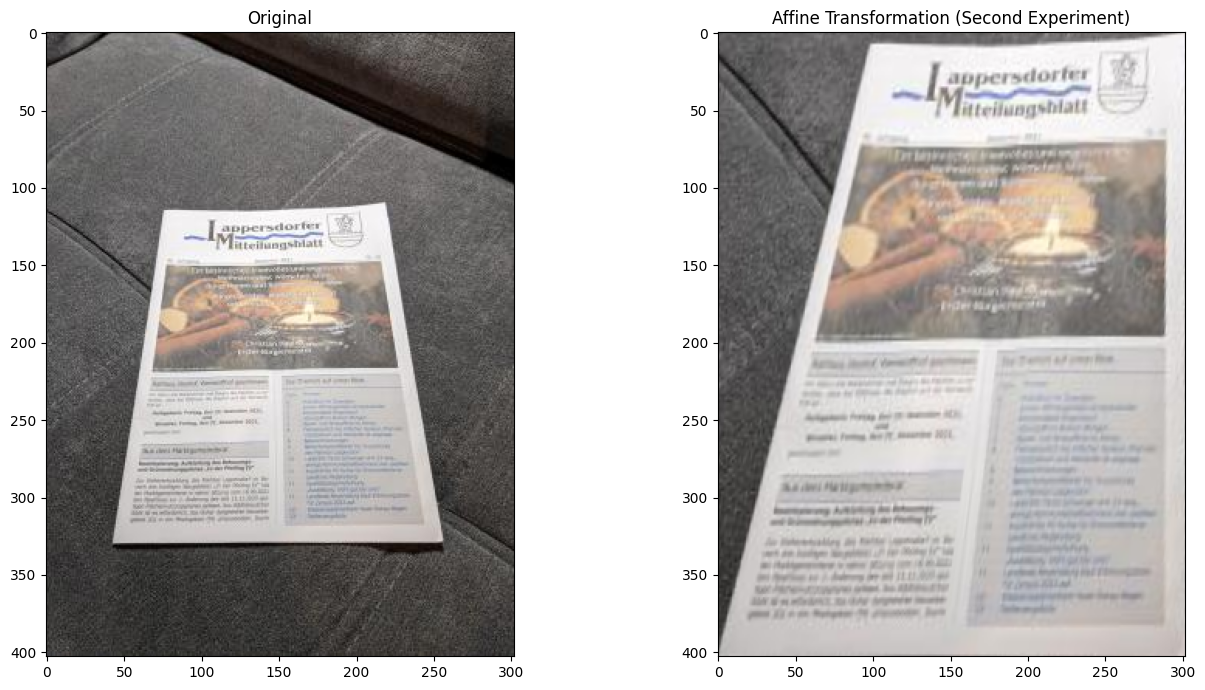

In [204]:
compare_two_images(img, rectified_2, 'Original', 'Affine Transformation (Second Experiment)')

The result differs but remains unsatisfactory, confirming that the limitation lies in the affine transformation model rather than in the selected points. 

### 1.3 Affine Transformation (Third Experiment)

In the third experiment, the affine transformation matrix is estimated using all four corner correspondences.  

Since four point pairs exceed the minimum requirement for an analytical affine solution, the matrix is computed using OpenCV’s optimization-based method (`estimateAffine2D`), which applies RANSAC to determine the best-fitting model.  

The estimated matrix is then applied to the image using `warpAffine`, and the resulting rectified image is analyzed to assess whether an optimized affine model improves the correction quality.



In [160]:
M, inliers = cv2.estimateAffine2D(src, dst, method=cv2.RANSAC)

rectified_3 = cv2.warpAffine(img, M, (cols, rows))

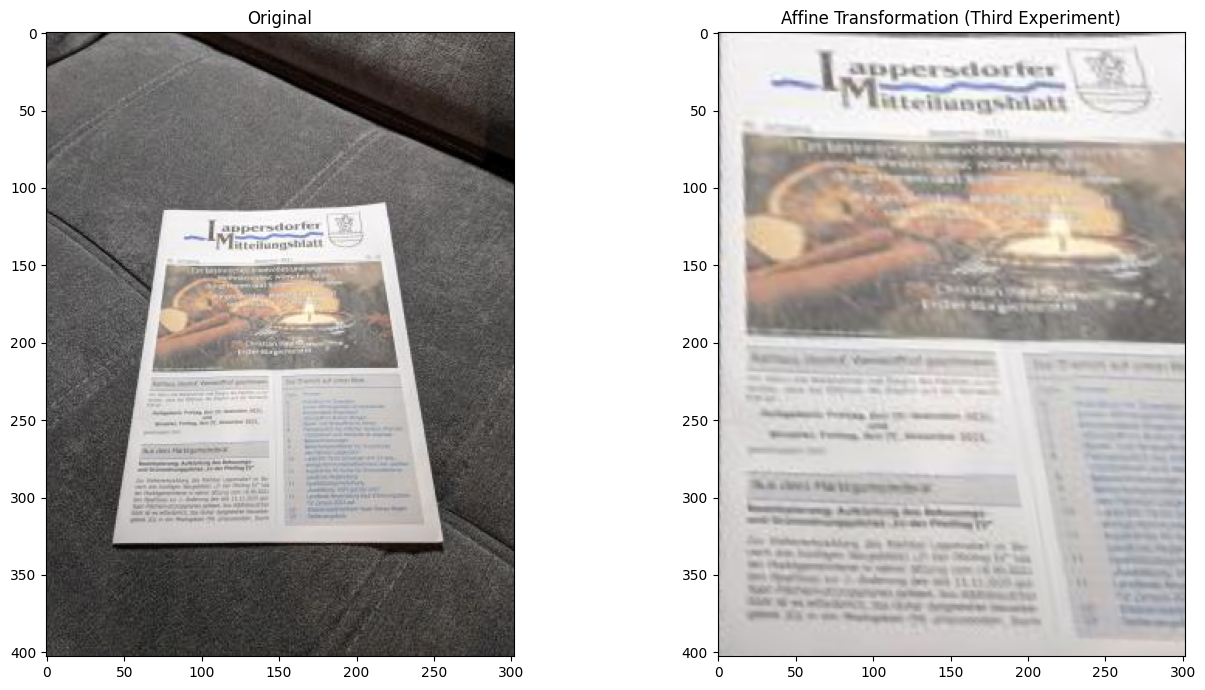

In [205]:
compare_two_images(img, rectified_3, 'Original', 'Affine Transformation (Third Experiment)')

The result does not significantly improve, even when all four points are used and the transformation is estimated via optimization. 
This confirms that the issue is inherent to the affine model, which cannot adequately correct perspective distortion.

### 1.4 Homography (Projective Transformation)

In the fourth experiment, a projective transformation (homography) is applied for document rectification.  

Unlike affine transformation, homography requires four point correspondences and is capable of modeling perspective distortion. The homography matrix is computed analytically from the four detected corner pairs using `cv2.getPerspectiveTransform`.  

The resulting matrix is then applied to the image using `warpPerspective`, producing a perspective-corrected rectangular view of the document.  


In [162]:
M = cv2.getPerspectiveTransform(src, dst)

rectified_4 = cv2.warpPerspective(img, M, (cols, rows))

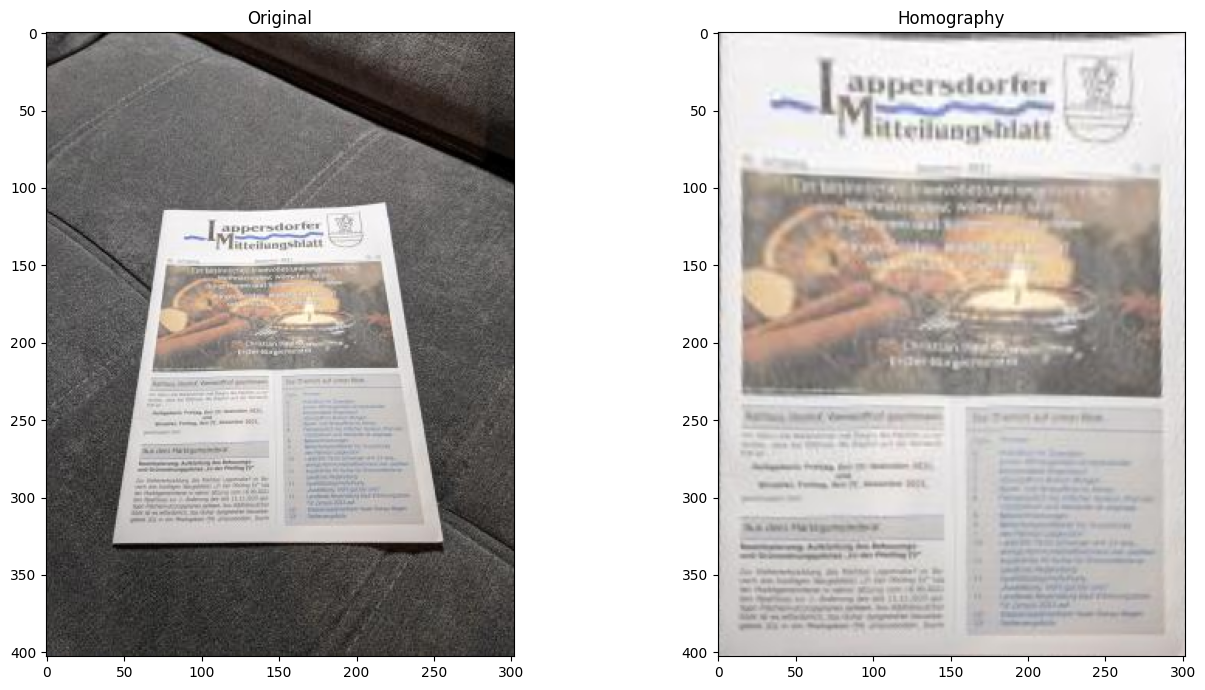

In [206]:
compare_two_images(img, rectified_4, 'Original', 'Homography')

The experimental results clearly demonstrate that affine transformations do not provide satisfactory rectification for this type of distortion. 

In contrast, the homography-based approach produces a geometrically consistent result and successfully corrects the perspective distortion. 

Thus, it is experimentally confirmed that affine models are insufficient, whereas projective transformation (homography) is appropriate for document rectification under perspective effects. 

## 2. Document Restoration Experiment: Music Sheet Rectification

In this experiment, a complete pipeline for restoring a distorted photograph of a music sheet is demonstrated.

The goal is to automatically detect the document, correct perspective distortion, fix orientation, adjust proportions to A4 format, and finally improve the white balance.

Shape: (900, 1600, 3)


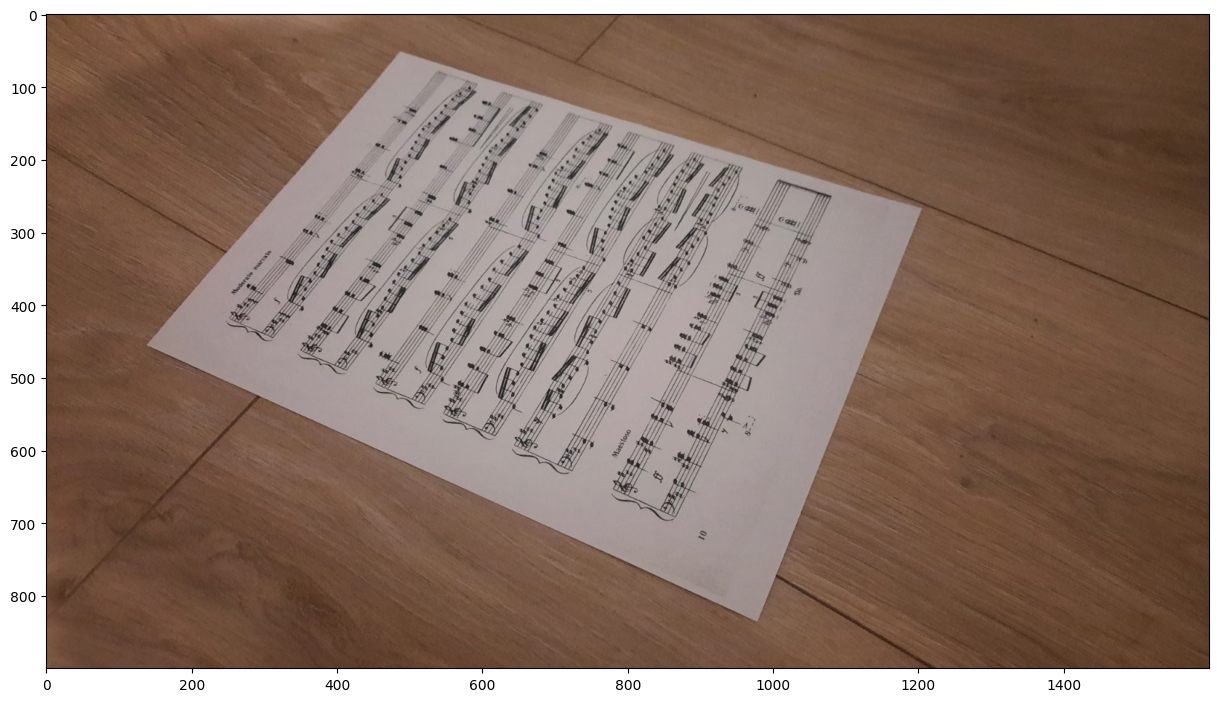

In [207]:
img2 = cv2.imread('data/music_sheet2.jpg')
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
print(f'Shape: {img2_rgb.shape}')
plt.imshow(img2_rgb)

### 2.1 Detecting Document Corners

The document corners are detected using the contour-based approach described in Section 1. The same edge and contour analysis pipeline is applied to extract the largest quadrilateral corresponding to the music sheet.

As a result, four extreme boundary points are obtained: top-left, top-right, bottom-left, and bottom-right.

This method is robust for documents placed on a contrasting background, which makes it particularly effective in this example.


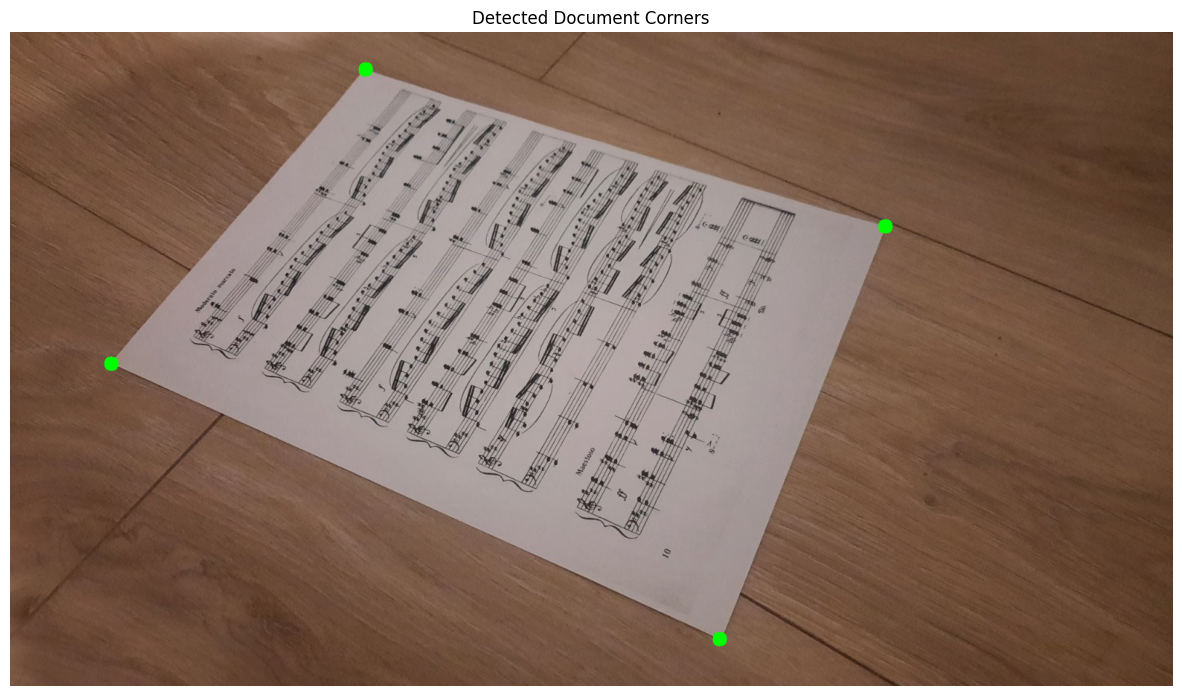

In [208]:
corners_img2 = detect_document_corners(img2)

out2 = img2.copy()

for pt in corners_img2:
    if pt is not None:
        out2 = cv2.circle(out2, pt, 10, (0,255,0), -1)

out_rgb2 = cv2.cvtColor(out2, cv2.COLOR_BGR2RGB)

plt.imshow(out_rgb2)
plt.title("Detected Document Corners")
plt.axis("off")
plt.show()

### 2.2 Perspective Rectification (Homography)

Once the document corners are detected, we compute a homography transformation.

Homography allows us to:

- Map the four detected corner points

- Transform the trapezoid-shaped document

- Restore it into a rectangular view


In [ ]:
def rectify_document(img, corners):

    top_left, top_right, bottom_left, bottom_right = corners

    rows, cols = img.shape[:2]

    src = np.array([top_left,
                    top_right,
                    bottom_right,
                    bottom_left], dtype=np.float32)

    dst = np.array([[0, 0],
                    [cols - 1, 0],
                    [cols - 1, rows - 1],
                    [0, rows - 1]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src, dst)

    rectified = cv2.warpPerspective(img, M, (cols, rows))

    return rectified


In [210]:
rectified_img2 = rectify_document(img2, corners_img2)

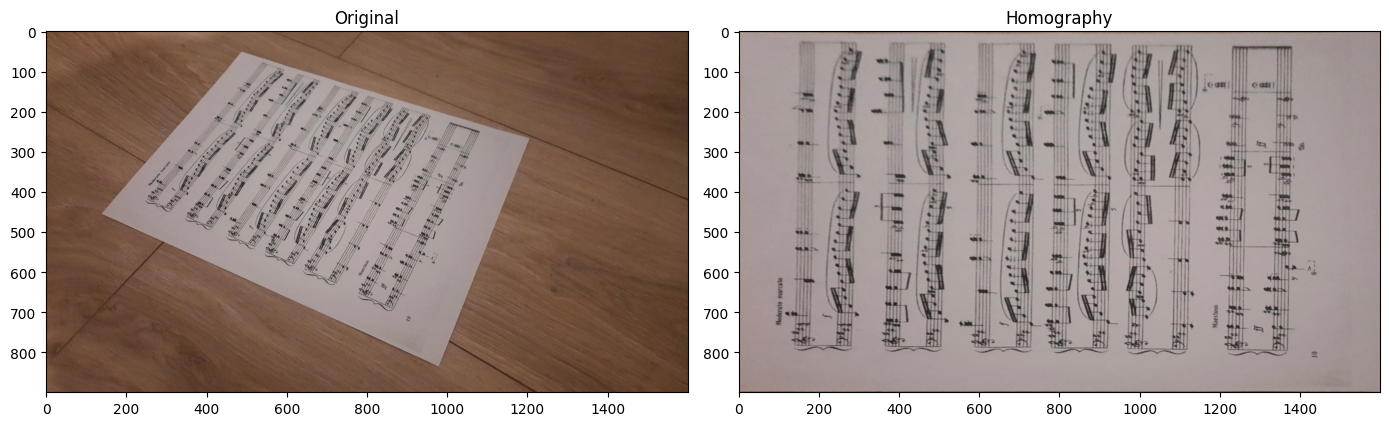

In [211]:
compare_two_images(img2, rectified_img2, 'Original', 'Homography')

This step removes perspective distortion.

However, at this stage the algorithm does not know where the top or bottom of the page is.
Homography only aligns geometry — it does not understand semantic orientation.

### 2.3 Orientation Correction and A4 Proportion Adjustment

Since the algorithm does not inherently determine which side of the document is "up", orientation must be defined according to the application context.

For music sheets, a structural rule is applied: the staff lines must be horizontal. Line segments are detected using the Hough Transform, and their orientations are analyzed by comparing the number of horizontal and vertical lines.

If vertical lines dominate, the page is rotated by 90 degrees to restore the correct structural alignment.

Even if the document remains upside down (180° rotation), it remains printable and can be manually rotated if necessary; therefore, the primary objective is to ensure correct structural orientation.

After orientation correction, the image proportions are adjusted to match the A4 aspect ratio (297/210 ≈ 1.414). This step compensates for residual geometric distortion introduced by perspective transformation.

Thus, this stage performs:

- Structural orientation correction  
- Proportion normalization to A4  


In [ ]:
def fix_orientation_by_lines(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    lines = cv2.HoughLinesP(edges,
                            rho=1,
                            theta=np.pi/180,
                            threshold=100,
                            minLineLength=200,
                            maxLineGap=20)

    if lines is not None:

        horizontal = 0
        vertical = 0

        for x1, y1, x2, y2 in lines[:,0]:
            dx = x2 - x1
            dy = y2 - y1

            if abs(dx) > abs(dy):
                horizontal += 1
            else:
                vertical += 1

        if vertical > horizontal:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

    h, w = img.shape[:2]

    A4_ratio = 297 / 210  # 1.414

    current_ratio = h / w

    if current_ratio > A4_ratio:
        new_w = int(h / A4_ratio)
        new_h = h
    else:
        new_h = int(w * A4_ratio)
        new_w = w

    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    return img


In [213]:
rectified_correct = fix_orientation_by_lines(rectified_img2)

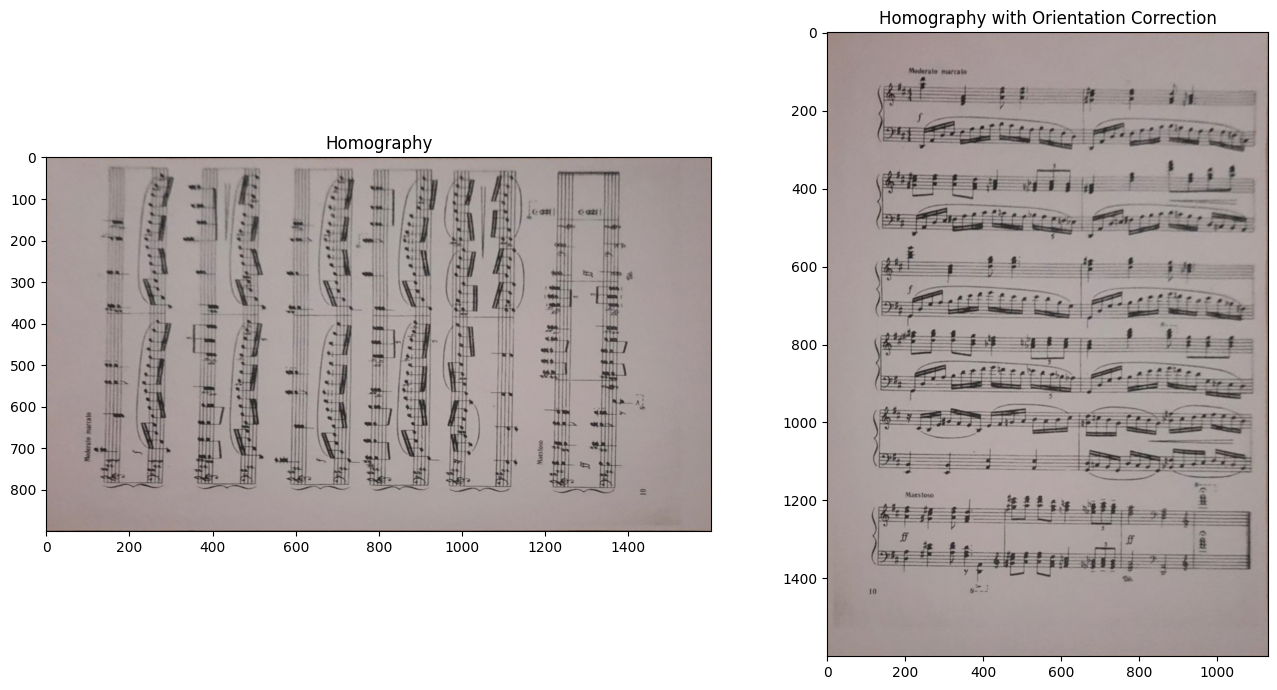

In [214]:
compare_two_images(rectified_img2, rectified_correct, 'Homography', 'Homography with Orientation Correction')

### 2.4 Soft White Balance Adjustment

To improve the visual quality of the music sheet, a soft White Patch method is applied.

The brightest pixels are used as a reference for white, and scaling factors are computed accordingly. Instead of applying full correction, a partial adjustment controlled by a strength parameter is used to avoid washing out dark notes.

This results in a cleaner background while preserving the contrast and readability of the musical notation.



In [ ]:
def white_balance_notes_soft(
    image_input,
    brightest_percent=99,
    strength=0.5
):

    if isinstance(image_input, str):
        img = cv2.imread(image_input)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_input.copy()

    img = img.astype(np.float32)

    brightness = img.mean(axis=2)
    threshold = np.percentile(brightness, brightest_percent)

    white_pixels = img[brightness >= threshold]

    if white_pixels.size == 0:
        return img.astype(np.uint8)

    ref_pixel = white_pixels.mean(axis=0)
    ref_pixel = np.maximum(ref_pixel, 1e-6)

    ideal_scale = 255.0 / ref_pixel

    scale = 1 + strength * (ideal_scale - 1)

    scale = np.clip(scale, 0.8, 1.5)

    img *= scale
    img = np.clip(img, 0, 255)

    return img.astype(np.uint8)

In [237]:
final = white_balance_notes_soft(rectified_correct, strength=0.9)

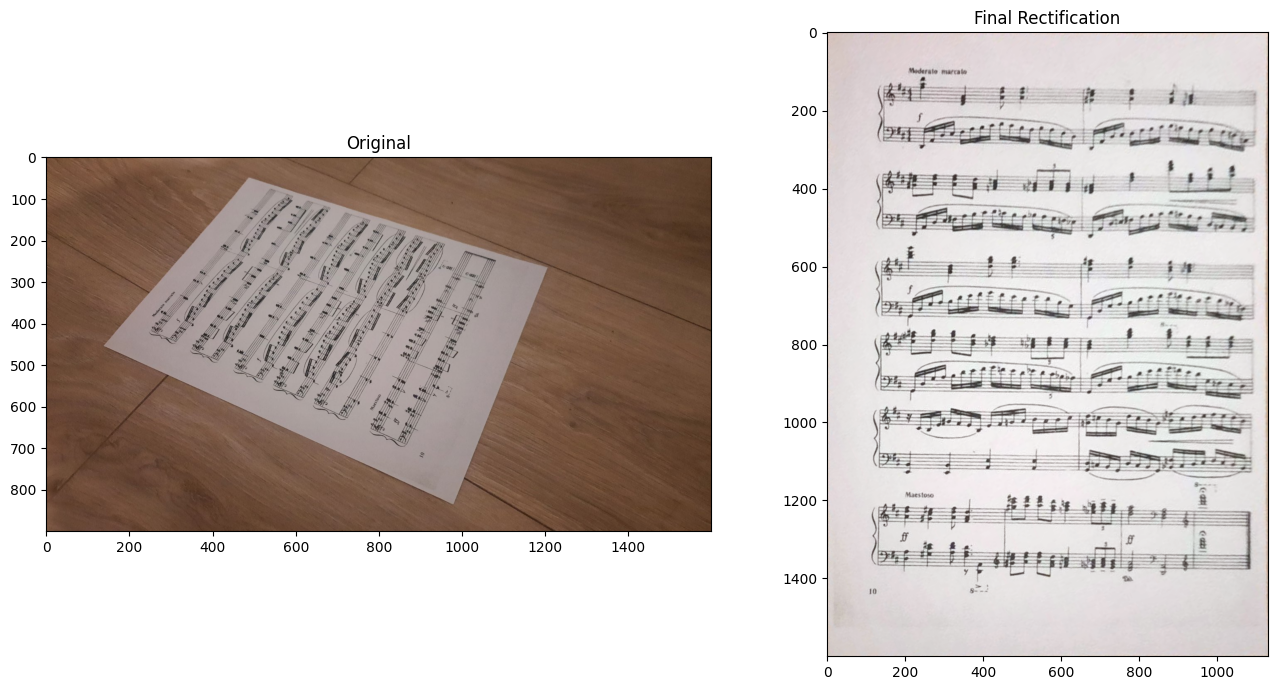

In [238]:
compare_two_images(img2, final, 'Original', 'Final Rectification')

The homography-based rectification successfully compensates for perspective distortion. However, additional spatial correction was required to normalize the document proportions.

A slight loss of sharpness is visible in the musical notation. This is partially caused by interpolation during the perspective transformation (`warpPerspective`). Additionally, since the document was originally captured at a strong viewing angle, some regions were compressed in the image and contained fewer pixels. 

When these compressed areas are stretched back during rectification, interpolation is required to reconstruct missing detail, which may lead to smoothing of fine structures such as thin staff lines and musical symbols.

## Questions

### 1. Why does the affine transform not work well in this case?

An affine transformation can model rotation, translation, scaling, and shear. It has **6 degrees of freedom** and preserves parallel lines.

However, the document in the image suffers from **perspective (projective) distortion**: the farther edge appears smaller and parallel lines converge. This type of distortion cannot be represented by an affine model.

Since affine transformations preserve parallelism, they cannot correctly map a trapezoid back to a true rectangle when perspective projection is present.

Therefore, affine transformation can only provide an approximation, but it cannot fully rectify the document.

### 2. What do the values of the inliers vector mean?

Using:

```python
M, inliers = cv2.estimateAffine2D(src, dst, method=cv2.RANSAC)
```

OpenCV estimates the best affine transformation using all point correspondences and returns:

- `M` — the estimated affine matrix  
- `inliers` — a binary mask indicating which correspondences fit the model  

Each element of `inliers` is:

- `1` → the point agrees with the estimated model  
- `0` → the point is treated as an outlier  

Since only four corner points are used, the mask indicates whether each corner is geometrically consistent with the best affine approximation.

If all values are `1`, it means all four points support the affine model. However, this does **not** imply that affine is the correct geometric model — only that all points agree with the best affine fit.

RANSAC increases robustness by reducing the influence of potentially mismatched correspondences.

### 3. How does the homography result look? Does it work well enough?

Homography models a full **projective transformation** with **8 degrees of freedom**, which allows it to represent perspective projection.

Unlike affine transformation, homography:

- does not preserve parallel lines  
- can map a trapezoid to a rectangle  
- correctly compensates for perspective distortion  

As a result, the document becomes properly rectified and aligned with the image borders.

Experimentally, homography provides a significantly better result than affine transformation and is the appropriate model for document rectification under perspective distortion.

However, homography only corrects geometric projection. It does **not** determine semantic orientation (top vs bottom). Orientation correction must be handled separately depending on the task.

The method works well as long as:

- the document is planar  
- the corner points are detected accurately  
- lens distortion is negligible  

If the paper is curved or the camera has strong lens distortion, additional camera calibration or non-linear correction would be required.